
___
# Conducting a Parameter Estimation
___

Author: Chenyu Wang

For this demonstration, we will be going through how to set up a parameter estimation using the Pyomo tool ***parmest***. This simple case study aims to validate the reverse osmosis model by the real plant data.

### Step 1: Imports
Import all Pyomo, WaterTAP and helper modules needed for building and solving the parameter estimation problem.

In [1]:
# Imports from Pyomo
from pyomo.environ import ConcreteModel, TerminationCondition, value, Reals, TransformationFactory, assert_optimal_termination
from pyomo.network import Arc
import pyomo.contrib.parmest.parmest as parmest # to perform the parameter estimation

# Imports from IDAES
from idaes.core import FlowsheetBlock
from idaes.models.unit_models import Feed, Separator
from idaes.core.util.initialization import propagate_state
from idaes.core.util.model_statistics import degrees_of_freedom
import idaes.core.util.scaling as iscale
import idaes.logger as idaeslog

# Imports from WaterTAP
from watertap.unit_models.reverse_osmosis_0D import ReverseOsmosis0D as RO, ConcentrationPolarizationType, MassTransferCoefficient
from watertap.property_models import seawater_prop_pack as props
from watertap.core.solvers import get_solver # to bring in ipopt solver

# Other imports
import pandas as pd # to create a pandas dataframe to organize the data
pd.options.mode.chained_assignment = None
import numpy as np # to manipulate the data into a usable format
import matplotlib.pyplot as plt # to plot the results
from utility_functions import load_data
import logging
logging.getLogger('pyomo.core').setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore")
np.seterr(all='ignore')
# warnings.filterwarnings(
#     "ignore",
#     message="invalid value encountered in scalar multiply",
#     category=RuntimeWarning
# )
solver = get_solver() # this will make the ipopt solver available

### Step 2: Gather and prepare the data
*How does data need to be formatted for parmest?*


- **Pandas Dataframe:** each column is an observed quantity (temperature, concentration, vapor pressure, etc.), each row is a distinct scenario (25, 0.02, 31.33)

**Other options:**
- **List of dictionaries:** each entry of the list is a distinct scenario, each key an observed quantity 
- **List of json file names:** each entry of the list contains a json file with the distinct scenario (for large datasets in parallel computing)

In this tutorial, we use the data collected from a pilot plan of **Orange County Water District (OCWD)** for a RO unit.

In [2]:
# Read in xlsx file to pd.dataframe
raw_data = pd.read_excel(r"Plant_data.xlsx")
# Prepare the data
data, full_data = load_data(raw_data)
display(data)

,flow_vol_in,mass_frac_TDS_in,pressure_in,deltaP,RO_recovery_%,flow_vol_permeate,mass_frac_TDS_permeate
31,6.011,0.001276,179.121,11.701,0.779737,4.687,24.26
32,6.035,0.001275,179.166,11.611,0.781442,4.716,24.53
33,6.049,0.001275,179.030,11.565,0.782278,4.732,24.53
34,6.037,0.001276,178.895,11.656,0.781514,4.718,24.49
35,6.024,0.001271,178.804,11.655,0.781873,4.710,24.53
36,6.050,0.001275,178.985,11.565,0.780826,4.724,24.53
37,6.060,0.001272,178.985,11.656,0.782178,4.740,24.53
38,6.034,0.001276,179.121,11.746,0.780245,4.708,24.49
39,6.035,0.001278,179.075,11.565,0.779453,4.704,24.58
40,6.026,0.001280,179.211,11.610,0.781945,4.712,24.67


### Step 3: Define the RO model for parameter estimation
*What model are parameters being fit to?*

***Parmest*** requires a "model function" to be defined that takes in the data and returns a Pyomo model.

Set up the Pyomo model defining:
- Pyomo Vars or Params for each parameter (or 'theta') to be estimated
- the model equation (a function of the observed data, i.e., permeate flow rate, mass fraction)

 

For this example, the RO model we are proposing is defined as `ro_parmest` function:


In [3]:
# Define global conversion factors
psi_to_pascal = 6894.75 # Pressure conversion
gpm_to_m3ps = 6.309e-005 # Vol. flow conversion

In [4]:
def ro_parmest(data):
    # Build the flowsheet
    m = ConcreteModel()
    m.fs = FlowsheetBlock(dynamic= False)
    m.fs.properties = props.SeawaterParameterBlock()
    m.fs.feed = Feed(property_package= m.fs.properties)
    m.fs.RO = RO(property_package=m.fs.properties,
                 has_pressure_change=True,
                 concentration_polarization_type=ConcentrationPolarizationType.none,
                 mass_transfer_coefficient=MassTransferCoefficient.none)

    m.fs.s00 = Arc(source=m.fs.feed.outlet, destination=m.fs.RO.inlet)
    TransformationFactory("network.expand_arcs").apply_to(m)

    # Set operating conditions
    m.fs.feed.properties[0].flow_vol_phase.fix(gpm_to_m3ps * 8)
    m.fs.feed.properties[0].temperature.fix(273.15 + 25)
    m.fs.feed.properties[0].pressure.fix(psi_to_pascal * 188)
    m.fs.feed.properties[0].mass_frac_phase_comp['Liq', 'TDS'].fix(0.001)

    m.fs.RO.area.fix(28.8) # Data is for 4 membrane elements
    m.fs.RO.permeate.pressure[0].fix(101325)
    m.fs.RO.deltaP.fix(-psi_to_pascal * 24.6)
    
    # Initialize A and B values (parameters)
    m.fs.RO.A_comp[0, 'H2O'].fix(5e-12)
    m.fs.RO.B_comp[0, 'TDS'].fix(4e-8)
    
    # Set scaling factors
    m.fs.properties.set_default_scaling('flow_mass_phase_comp', 1e1, index=('Liq','H2O'))
    m.fs.properties.set_default_scaling('flow_mass_phase_comp', 1e6, index=('Liq', 'TDS'))
    iscale.set_scaling_factor(m.fs.RO.area, 1e-1)
    iscale.calculate_scaling_factors(m)

    # Initialize the system
    solver.solve(m.fs.feed)
    propagate_state(m.fs.s00)
    m.fs.RO.initialize(outlvl=idaeslog.ERROR)
    
    # Set actual operating conditions based on the data
    m.fs.feed.properties[0].flow_vol_phase.fix(gpm_to_m3ps * float(data.iloc[0]['flow_vol_in']))
    m.fs.feed.properties[0].pressure.fix(psi_to_pascal * float(data.iloc[0]['pressure_in']))
    m.fs.feed.properties[0].mass_frac_phase_comp['Liq', 'TDS'].fix(float(data.iloc[0]['mass_frac_TDS_in']))
    m.fs.RO.deltaP.fix(-psi_to_pascal * float(data.iloc[0]['deltaP']))

    assert degrees_of_freedom(m) == 0

    return m


### Step 4: Define a list of parameter names

The variables to be estimated by parmest must be given as a list of strings of the variable names as they are defined in the `ro_parmest`. 

In [5]:
# variables from model to be estimated
# required format: list with strings of param/var names
theta_names = ["fs.RO.A_comp[0, 'H2O']", "fs.RO.B_comp[0, 'TDS']"]

### Step 5: Define an objective function

Now, we should define an objective function for the parameter estimation. This is the deviation between the observation and the prediction typically chosen to be the sum of squared errors.

$$
\sum_{i=0}^n (observation_i - prediction_i)^2 
$$


In [6]:
# Sum of Squared Errors function
def SSE(m, data):
    flow_vol_scale =  1/1.909522782100071e-05 #14318 # stdev of permeate flow #  1e2
    mass_comp_scale = 1/2.4388414228794023e-06 #379457 # stdev of permeate salinity #  1e4 
    expr = (
         10*flow_vol_scale*((gpm_to_m3ps*float(data.iloc[0]['flow_vol_permeate']) - m.fs.RO.mixed_permeate[0.0].flow_vol_phase['Liq'])**2) 
         + 1000*mass_comp_scale*((1e-6*float(data.iloc[0]['mass_frac_TDS_permeate'])- m.fs.RO.mixed_permeate[0.0].mass_frac_phase_comp['Liq', 'TDS'])**2)
            )
    return expr

### Step 6: Solve the parameter estimation problem

Now, we have everything we need for parmest to solve the parameter estimation problem: 

    - ro_parmest
    - data
    - theta_names
    - objective_function


#### Step 6a: Set up the problem

Set up the parameter estimation problem by creating an instance of the parmest 'Estimator' object and feed it the required inputs.

In [7]:
# create an instance of the parmest estimator
pest = parmest.Estimator(ro_parmest, data, theta_names, SSE, tee=False)

(model_function, data, theta_names). This interface will be removed in a
future release, please update to the new parmest interface using experiment
lists.  (deprecated in 6.7.2) (called from
C:\Users\wcy78\anaconda3\envs\watertap-dev\Lib\functools.py:946)


#### Step 6b: Solve the parameter estimation problem 

Solve the parameter estimation problem by calling theta_est. This will use the entire data set to perform the parameter estimation. 

There are additional options for solving and testing. Further details can be found in the [parmest documentation](https://pyomo.readthedocs.io/en/6.7.0/contributed_packages/parmest/index.html).

In [8]:
# solve the parameter estimation problem
obj, theta = pest.theta_est()

# display results
print('theta:\n', theta)

component keys that are not exported as part of the NL file.  Skipping.
theta:
 fs.RO.A_comp[0.0,H2O]    1.216983e-11
fs.RO.B_comp[0.0,TDS]    7.276057e-08
dtype: float64


### Step 7: Visualize results

Finally, we can visualize the results using ***matplotlib*** to create a plot of the data and the parameter estimatation fit. 

#### Step 7.1: Define the model with the optimal parameters

In [9]:
def ro_opt():
    # Build the flowsheet
    m = ConcreteModel()
    m.fs = FlowsheetBlock(dynamic= False)
    m.fs.properties = props.SeawaterParameterBlock()
    m.fs.feed = Feed(property_package= m.fs.properties)
    m.fs.RO = RO(property_package=m.fs.properties,
                 has_pressure_change=True,
                 concentration_polarization_type=ConcentrationPolarizationType.none,
                 mass_transfer_coefficient=MassTransferCoefficient.none)

    m.fs.s00 = Arc(source=m.fs.feed.outlet, destination=m.fs.RO.inlet)
    TransformationFactory("network.expand_arcs").apply_to(m)

    # Set initial conditions
    m.fs.feed.properties[0].flow_vol_phase.fix(gpm_to_m3ps * 8)
    m.fs.feed.properties[0].temperature.fix(273.15 + 25)
    m.fs.feed.properties[0].pressure.fix(psi_to_pascal * 188)
    m.fs.feed.properties[0].mass_frac_phase_comp['Liq', 'TDS'].fix(0.001)

    m.fs.RO.area.fix(28.8) # Data is for 4 membrane elements
    m.fs.RO.permeate.pressure[0].fix(101325)
    m.fs.RO.deltaP.fix(-psi_to_pascal * 24.6)
    
    # Set optimal values of parameters from parmest
    m.fs.RO.A_comp[0, 'H2O'].fix(theta.iloc[0])
    m.fs.RO.B_comp[0, 'TDS'].fix(theta.iloc[1])
    
    # Set scaling factors
    m.fs.properties.set_default_scaling('flow_mass_phase_comp', 1e1, index=('Liq','H2O'))
    m.fs.properties.set_default_scaling('flow_mass_phase_comp', 1e6, index=('Liq', 'TDS'))
    iscale.set_scaling_factor(m.fs.RO.area, 1e-1)
    iscale.calculate_scaling_factors(m)

    # Initialize the system
    solver.solve(m.fs.feed)
    propagate_state(m.fs.s00)
    m.fs.RO.initialize(outlvl=idaeslog.ERROR)

    assert degrees_of_freedom(m) == 0

    return m

#### Step 7.2: Create a table to save model results

In [10]:
# Create a new table to save model results
model_results=full_data.copy()
m = ro_opt()
for i in range(model_results.shape[0]):
    # Conversion factors
    psi_to_pascal = 6894.75 # Pressure conversion
    gpm_to_m3ps = 6.309e-005 # Vol. flow conversion
    
    # Update operating conditions
    m.fs.feed.properties[0].flow_vol_phase.fix(gpm_to_m3ps * float(model_results.iloc[i]['flow_vol_in']))
    m.fs.feed.properties[0].pressure.fix(psi_to_pascal * float(model_results.iloc[i]['pressure_in']))
    m.fs.feed.properties[0].mass_frac_phase_comp['Liq', 'TDS'].fix(float(model_results.iloc[i]['mass_frac_TDS_in']))
    m.fs.RO.deltaP.fix(-psi_to_pascal * float(model_results.iloc[i]['deltaP']))

    results = solver.solve(m, tee=False)
    assert_optimal_termination(results)
    
    model_results.iloc[i, 5] = value(m.fs.RO.mixed_permeate[0.0].flow_vol_phase['Liq']) / gpm_to_m3ps
    model_results.iloc[i, 6] = value(m.fs.RO.mixed_permeate[0.0].mass_frac_phase_comp['Liq', 'TDS']) / 1e-6

#### Step 7.3: Visualize model vs data comparison

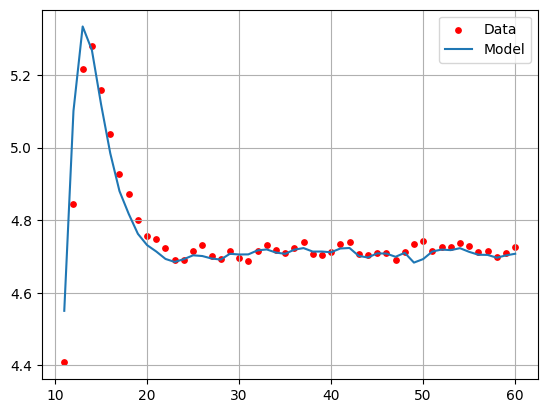

In [11]:
plt.figure()
plt.scatter(full_data.index, full_data['flow_vol_permeate'], label='Data', color='red', s=15)
plt.plot(model_results.index, model_results['flow_vol_permeate'], label='Model')
plt.legend()
plt.grid(True)
plt.show()

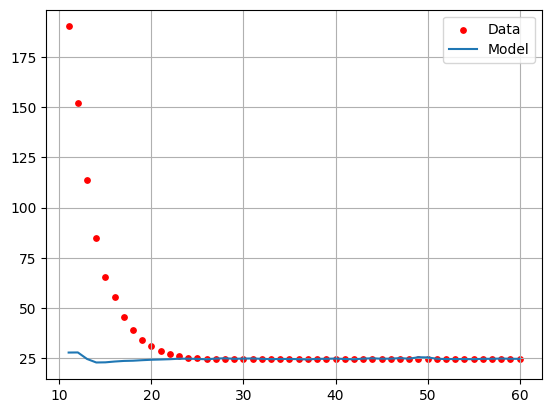

In [12]:
plt.figure()
plt.scatter(full_data.index, full_data['mass_frac_TDS_permeate'], label='Data', color='red', s=15)
plt.plot(model_results.index, model_results['mass_frac_TDS_permeate'], label='Model')
plt.legend()
plt.grid(True)
plt.show()